# FCEF Early Fusion Baseline

Fair comparison setup: shared splits, patch size (64x64), normalization, and random seeds with U-Net baseline.

In [ ]:
import sys
import random
from pathlib import Path

import numpy as np
import torch

root = Path().resolve().parents[0]
sys.path.append(str(root))

In [3]:
from dotenv import load_dotenv
import os

load_dotenv()
api_key = os.getenv("WANDB_API_KEY")

## Set Random Seeds

In [ ]:
RANDOM_SEED = 42

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(f"All random seeds set to {RANDOM_SEED}")

## Train/Val/Test Splits

Shared splits with U-Net: 70/15/15, random_state=42

In [ ]:
from src.data.splits import get_splits, get_ref_ids_from_directory
from src.data.timeseries_dataset import TimeSeriesDataset
from src.config import SENTINEL_DIR, MASK_DIR

all_ref_ids = get_ref_ids_from_directory(SENTINEL_DIR)
print(f"Total reference IDs found: {len(all_ref_ids)}")

train_ref_ids, val_ref_ids, test_ref_ids = get_splits(
    all_ref_ids,
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15,
    random_state=RANDOM_SEED,
)

print(f"\nTrain tiles: {len(train_ref_ids)} (~{100*len(train_ref_ids)/len(all_ref_ids):.0f}%)")
print(f"Val tiles: {len(val_ref_ids)} (~{100*len(val_ref_ids)/len(all_ref_ids):.0f}%)")
print(f"Test tiles: {len(test_ref_ids)} (~{100*len(test_ref_ids)/len(all_ref_ids):.0f}%)")
print(f"\nExample train ID: {train_ref_ids[0]}")
print(f"\n✓ Using SHARED splits with U-Net baseline (random_state={RANDOM_SEED})")

C:\Users\emma\Documents\Land-Take-Prediction-Project-NINA-\data\raw\Sentinel\a26-040070508867_45-95719246129747_RGBNIRRSWIRQ_Mosaic.tif


## Compute Normalization Stats

From training set only (shared with U-Net).

In [ ]:
from src.data.transform import compute_normalization_stats, NormalizeBy, ComposeTS

temp_train_transform = ComposeTS([NormalizeBy(10000.0)])

temp_train_ds = TimeSeriesDataset(
    train_ref_ids, 
    sensor="sentinel", 
    slice_mode="first_half", 
    transform=temp_train_transform
)

print("Estimating per-channel mean and std from training data...")
mean, std = compute_normalization_stats(temp_train_ds, num_samples=2000)
print(f"✓ Computed normalization stats: {len(mean)} channels")
print(f"  Mean (first 5): {[f'{m:.4f}' for m in mean[:5]]}")
print(f"  Std (first 5): {[f'{s:.4f}' for s in std[:5]]}")

## Create Datasets

Shared normalization: scale by 10000 + mean/std standardization
Patch size: 64x64, temporal slicing: first_half (7 time steps)

In [ ]:
from src.data.transform import ComposeTS, NormalizeBy, RandomCropTS, CenterCropTS, Normalize

CROP = 64

train_transform = ComposeTS([
    NormalizeBy(10000.0),
    Normalize(mean, std),
    RandomCropTS(CROP),
])

val_transform = ComposeTS([
    NormalizeBy(10000.0),
    Normalize(mean, std),
    CenterCropTS(CROP),
])

test_transform = ComposeTS([
    NormalizeBy(10000.0),
    Normalize(mean, std),
    CenterCropTS(CROP),
])

train_ds = TimeSeriesDataset(train_ref_ids, sensor="sentinel", slice_mode="first_half", transform=train_transform)
val_ds = TimeSeriesDataset(val_ref_ids, sensor="sentinel", slice_mode="first_half", transform=val_transform)
test_ds = TimeSeriesDataset(test_ref_ids, sensor="sentinel", slice_mode="first_half", transform=test_transform)

print(f"✓ Datasets created with SHARED normalization and patch_size={CROP}")
print(f"Train samples: {len(train_ds)} tiles")
print(f"Val samples: {len(val_ds)} tiles")
print(f"Test samples: {len(test_ds)} tiles")

In [ ]:
from torch.utils.data import DataLoader

def worker_init_fn(worker_id):
    worker_seed = RANDOM_SEED + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# Create dataloaders with reproducible shuffling
train_loader = DataLoader(
    train_ds, 
    batch_size=4, 
    shuffle=True, 
    num_workers=4,
    worker_init_fn=worker_init_fn,
    generator=torch.Generator().manual_seed(RANDOM_SEED)
)
val_loader = DataLoader(val_ds, batch_size=4, shuffle=False, num_workers=4)
test_loader = DataLoader(test_ds, batch_size=4, shuffle=False, num_workers=4)

print(f"✓ Dataloaders created with reproducible shuffling (seed={RANDOM_SEED})")

In [ ]:
import torch
from src.models.external.torchrs_fc_cd import FCEF

device = "cuda" if torch.cuda.is_available() else "cpu"

sample_x, _ = next(iter(train_loader))
_, T, C, H, W = sample_x.shape

model = FCEF(channels=C, t=T, num_classes=2).to(device)
model

FCEF(
  (encoder): Encoder(
    (0): ConvBlock(
      (model): Sequential(
        (0): Conv2d(63, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0.2, inplace=False)
        (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (6): ReLU()
        (7): Dropout(p=0.2, inplace=False)
      )
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): ConvBlock(
      (model): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0.2, inplace=False)
        (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding

In [ ]:
import torch

def compute_confusion_binary(y_pred, y_true, positive_class=1):
    y_pred = (y_pred == positive_class)
    y_true = (y_true == positive_class)

    tp = (y_pred & y_true).sum().item()
    fp = (y_pred & ~y_true).sum().item()
    tn = (~y_pred & ~y_true).sum().item()
    fn = (~y_pred & y_true).sum().item()
    return tp, fp, tn, fn

def compute_metrics_from_confusion(tp, fp, tn, fn, eps=1e-8):
    accuracy  = (tp + tn) / (tp + tn + fp + fn + eps)
    precision = tp / (tp + fp + eps)
    recall    = tp / (tp + fn + eps)
    f1        = 2 * precision * recall / (precision + recall + eps)
    iou       = tp / (tp + fp + fn + eps)
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "iou": iou,
    }

def compute_batch_metrics(logits, mask, positive_class=1):
    with torch.no_grad():
        pred = torch.argmax(logits, dim=1)
        tp, fp, tn, fn = compute_confusion_binary(pred, mask, positive_class)
        return compute_metrics_from_confusion(tp, fp, tn, fn)

In [ ]:
import torch
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm
import wandb

lr = 1e-3

run = wandb.init(
    entity="nina_prosjektoppgave",
    project="FCEarlyFusion",
    config={
        "learning_rate": lr,
        "architecture": "FCEF",
        "dataset": "sentinel",
        "epochs": 10,
        "batch_size": 4,
        "patch_size": CROP,
        "temporal_mode": "first_half",
        "num_timesteps": 7,
        "train_tiles": len(train_ref_ids),
        "val_tiles": len(val_ref_ids),
        "test_tiles": len(test_ref_ids),
        "normalization": "scale_10000_plus_standardize",
        "random_seed": RANDOM_SEED,
        "train_ratio": 0.7,
        "val_ratio": 0.15,
        "test_ratio": 0.15,
        "fair_comparison": "shared_splits_normalization_patch_size_with_UNet",
    },
)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=lr)
scaler = torch.amp.GradScaler("cuda")

for epoch in range(10):
    model.train()
    total_loss = 0.0
    for x, mask in tqdm(train_loader, desc=f"epoch {epoch+1}"):
        x = x.to(device)
        mask = mask.to(device)
        
        optimizer.zero_grad()
        with torch.amp.autocast('cuda'):
            logits = model(x)
            loss = criterion(logits, mask)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)

    model.eval()
    val_loss = 0.0
    sum_tp = sum_fp = sum_tn = sum_fn = 0
    with torch.no_grad():
        for x, mask in val_loader:
            x = x.to(device)
            mask = mask.to(device)
            with torch.amp.autocast('cuda'):
                logits = model(x)
                loss = criterion(logits, mask)
            val_loss += loss.item()

            pred = torch.argmax(logits, dim=1)
            tp, fp, tn, fn = compute_confusion_binary(pred, mask, positive_class=1)
            sum_tp += tp
            sum_fp += fp
            sum_tn += tn
            sum_fn += fn

    avg_val_loss = val_loss / len(val_loader)
    val_metrics = compute_metrics_from_confusion(sum_tp, sum_fp, sum_tn, sum_fn)

    run.log({
        "epoch": epoch + 1,
        "avg_train_loss": avg_train_loss,
        "avg_val_loss": avg_val_loss,
        "IoU": val_metrics['iou'],
        "F1": val_metrics['f1'],
        "Precision": val_metrics['precision'],
        "Recall": val_metrics['recall'],
        "Accuracy": val_metrics['accuracy']
    })

    print(
        f"epoch {epoch+1}: "
        f"avg_train_loss={avg_train_loss:.4f} "
        f"avg_val_loss={avg_val_loss:.4f} "
        f"IoU={val_metrics['iou']:.4f} "
        f"F1={val_metrics['f1']:.4f} "
        f"Prec={val_metrics['precision']:.4f} "
        f"Rec={val_metrics['recall']:.4f} "
        f"Acc={val_metrics['accuracy']:.4f}"
    )

run.finish()

print(f"\nTraining Complete!")
print(f"Final Validation Metrics:")
print(f"  Loss: {avg_val_loss:.4f}")
print(f"  IoU: {val_metrics['iou']:.4f}")
print(f"  F1: {val_metrics['f1']:.4f}")

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


C:\Users\emma\AppData\Local\Temp\ipykernel_19560\1323980386.py:26: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  scaler = torch.amp.GradScaler("cuda")
epoch 1:   0%|          | 0/12 [00:00<?, ?it/s]c:\Users\emma\Documents\Land-Take-Prediction-Project-NINA-\prosjekt_venv\Lib\site-packages\torch\amp\autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
epoch 1: 100%|██████████| 12/12 [00:09<00:00,  1.27it/s]


epoch 1: train=0.6596 val=0.7359 IoU=0.3609 F1=0.5304 Prec=1.0000 Rec=0.3609 Acc=0.3609


epoch 2: 100%|██████████| 12/12 [00:09<00:00,  1.28it/s]


epoch 2: train=0.6204 val=0.8182 IoU=0.3693 F1=0.5394 Prec=1.0000 Rec=0.3693 Acc=0.3693


epoch 3: 100%|██████████| 12/12 [00:09<00:00,  1.28it/s]


epoch 3: train=0.5877 val=0.6260 IoU=0.2655 F1=0.4197 Prec=1.0000 Rec=0.2655 Acc=0.2655


epoch 4: 100%|██████████| 12/12 [00:09<00:00,  1.24it/s]


epoch 4: train=0.5636 val=1.4988 IoU=0.4946 F1=0.6618 Prec=1.0000 Rec=0.4946 Acc=0.4946


epoch 5: 100%|██████████| 12/12 [00:09<00:00,  1.23it/s]


epoch 5: train=0.5520 val=1.3750 IoU=0.4970 F1=0.6640 Prec=1.0000 Rec=0.4970 Acc=0.4970


epoch 6: 100%|██████████| 12/12 [00:09<00:00,  1.29it/s]


epoch 6: train=0.5407 val=0.6221 IoU=0.5162 F1=0.6809 Prec=1.0000 Rec=0.5162 Acc=0.5162


epoch 7: 100%|██████████| 12/12 [00:09<00:00,  1.22it/s]


epoch 7: train=0.5270 val=0.5104 IoU=0.5061 F1=0.6720 Prec=1.0000 Rec=0.5061 Acc=0.5061


epoch 8: 100%|██████████| 12/12 [00:09<00:00,  1.30it/s]


epoch 8: train=0.5172 val=0.6026 IoU=0.6147 F1=0.7614 Prec=1.0000 Rec=0.6147 Acc=0.6147


epoch 9: 100%|██████████| 12/12 [00:12<00:00,  1.01s/it]


epoch 9: train=0.5069 val=0.5605 IoU=0.6595 F1=0.7949 Prec=1.0000 Rec=0.6595 Acc=0.6595


epoch 10: 100%|██████████| 12/12 [00:09<00:00,  1.33it/s]


epoch 10: train=0.4944 val=0.5402 IoU=0.3868 F1=0.5578 Prec=1.0000 Rec=0.3868 Acc=0.3868


Accuracy,▃▃▁▅▅▅▅▇█▃
F1,▃▃▁▆▆▆▆▇█▄
IoU,▃▃▁▅▅▅▅▇█▃
Precision,▁▁▁▁▁▁▁▁▁▁
Recall,▃▃▁▅▅▅▅▇█▃
avg_train_loss,█▆▅▄▃▃▂▂▂▁
avg_val_loss,▃▃▂█▇▂▁▂▁▁
Accuracy,0.38676
F1,0.55779
IoU,0.38676
Precision,1.0


In [ ]:
import matplotlib.pyplot as plt

def visualize_batch(model, data_loader, device, num_examples=3):
    model.eval()
    x, mask = next(iter(data_loader))  # one batch
    x = x.to(device)
    mask = mask.to(device)

    with torch.no_grad():
        logits = model(x)
        pred = torch.argmax(logits, dim=1)  # (B, H, W)

    # move to cpu for plotting
    x_cpu = x.cpu()
    mask_cpu = mask.cpu()
    pred_cpu = pred.cpu()

    B, T, C, H, W = x_cpu.shape
    num_examples = min(num_examples, B)

    for i in range(num_examples):
        img = x_cpu[i, -1, :3]
        img_min = img.min()
        img_max = img.max()
        img_vis = (img - img_min) / (img_max - img_min + 1e-8)
        img_vis = img_vis.permute(1, 2, 0)

        gt = mask_cpu[i]
        pr = pred_cpu[i]
        
        fig, axes = plt.subplots(1, 3, figsize=(10, 4))
        axes[0].imshow(img_vis)
        axes[0].set_title("Input (t_last, RGB-ish)")
        axes[0].axis("off")

        axes[1].imshow(gt, vmin=0, vmax=1)
        axes[1].set_title("Ground truth mask")
        axes[1].axis("off")

        axes[2].imshow(pr, vmin=0, vmax=1)
        axes[2].set_title("Predicted mask")
        axes[2].axis("off")

        plt.tight_layout()
        plt.show()


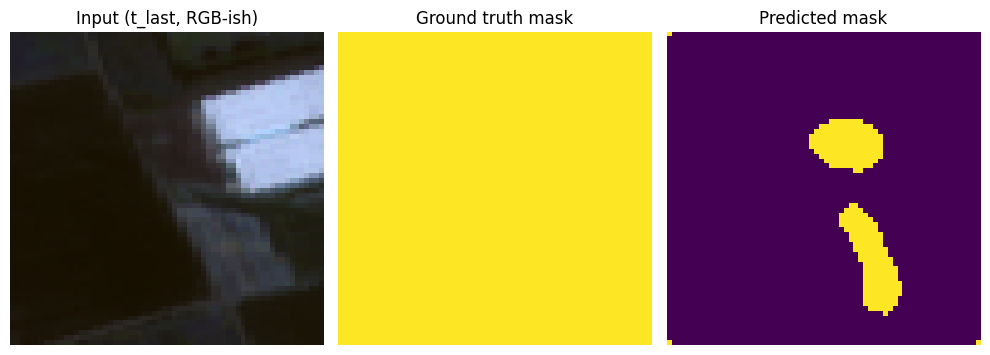

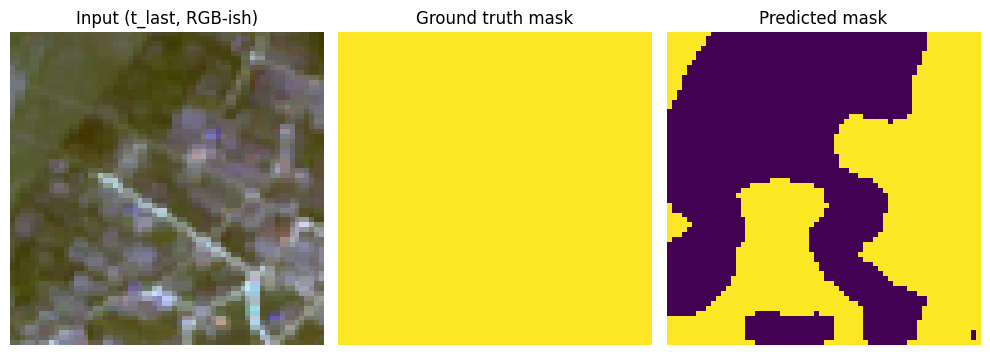

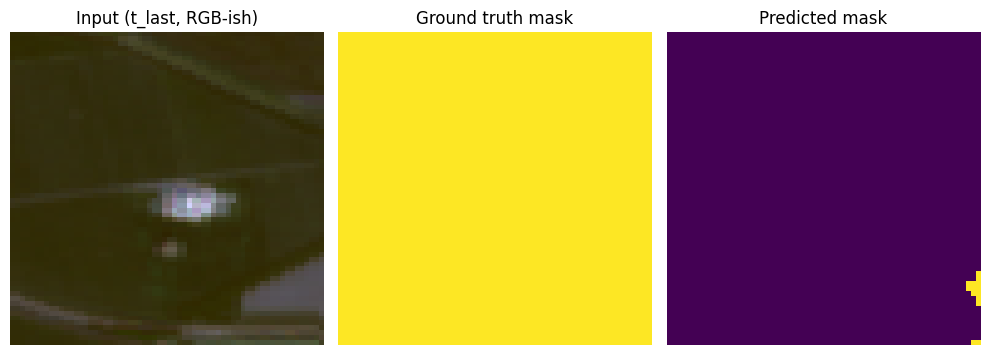

In [15]:
visualize_batch(model, val_loader, device, num_examples=3)

## Test Set Evaluation

In [ ]:
model.eval()
test_loss = 0.0
sum_tp = sum_fp = sum_tn = sum_fn = 0

with torch.no_grad():
    for x, mask in tqdm(test_loader, desc="Testing"):
        x = x.to(device)
        mask = mask.to(device)
        
        with torch.amp.autocast('cuda'):
            logits = model(x)
            loss = criterion(logits, mask)
        
        test_loss += loss.item()
        
        pred = torch.argmax(logits, dim=1)
        tp, fp, tn, fn = compute_confusion_binary(pred, mask, positive_class=1)
        sum_tp += tp
        sum_fp += fp
        sum_tn += tn
        sum_fn += fn

avg_test_loss = test_loss / len(test_loader)
test_metrics = compute_metrics_from_confusion(sum_tp, sum_fp, sum_tn, sum_fn)

print(f"\n{'='*60}")
print(f"Test Set Results (Shared test set with U-Net baseline):")
print(f"{'='*60}")
print(f"  Loss: {avg_test_loss:.4f}")
print(f"  IoU: {test_metrics['iou']:.4f}")
print(f"  F1: {test_metrics['f1']:.4f}")
print(f"  Precision: {test_metrics['precision']:.4f}")
print(f"  Recall: {test_metrics['recall']:.4f}")
print(f"  Accuracy: {test_metrics['accuracy']:.4f}")
print(f"{'='*60}")

wandb.log({
    "test_loss": avg_test_loss,
    "test_iou": test_metrics['iou'],
    "test_f1": test_metrics['f1'],
    "test_precision": test_metrics['precision'],
    "test_recall": test_metrics['recall'],
    "test_accuracy": test_metrics['accuracy'],
})